<a href="https://colab.research.google.com/github/syaq1603/roundworm_classifier/blob/main/Roundworm_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


In [2]:
import os
print(os.listdir("/content/sample_data/WormImages"))



['wormA18.tif', 'wormD01.tif', 'wormC23.tif', 'wormB19.tif', 'wormC24.tif', 'wormA09.tif', 'wormA20.tif', 'wormD17.tif', 'wormD19.tif', 'wormB07.tif', 'wormA11.tif', 'wormD07.tif', 'wormB08.tif', 'wormA13.tif', 'wormA22.tif', 'wormA04.tif', 'wormC01.tif', 'wormD22.tif', 'wormB04.tif', 'wormB23.tif', 'wormC20.tif', 'wormC18.tif', 'wormB18.tif', 'wormA17.tif', 'wormD18.tif', 'wormD11.tif', 'wormC03.tif', 'wormD21.tif', 'wormD14.tif', 'wormA23.tif', 'wormA08.tif', 'wormC02.tif', 'wormD02.tif', 'wormC04.tif', 'wormC08.tif', 'wormA07.tif', 'wormC11.tif', 'wormC15.tif', 'wormA03.tif', 'wormB02.tif', 'wormD09.tif', 'wormA12.tif', 'wormB14.tif', 'wormB06.tif', 'wormD23.tif', 'wormA01.tif', 'wormD08.tif', 'wormC05.tif', 'wormD15.tif', 'wormC09.tif', 'wormD04.tif', 'wormB15.tif', 'wormD05.tif', 'wormB09.tif', 'wormA06.tif', 'wormA05.tif', 'wormD10.tif', 'wormD16.tif', 'wormC12.tif', 'wormB16.tif', 'wormB20.tif', 'wormB17.tif', 'wormC10.tif', 'wormA10.tif', 'wormA24.tif', 'wormD06.tif', 'wormA02.

In [3]:
image_dir = '/content/sample_data/WormImages'


In [4]:
file_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
labels = [0 if 'wormA' in f else 1 for f in file_list]


In [5]:

print(f"{len(file_list)} images found.")

93 images found.


 - Load and preprocess images

 - Read .tif images in grayscale

 - Resize to a standard size (e.g. 128x128)

 - Normalize pixel values

 - Expand dimensions for TensorFlow

 - Train with MobileNetV2



In [6]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Preprocessing
image_size = (128, 128)

def load_images(files, folder, size):
    images = []
    for fname in files:
        path = os.path.join(folder, fname)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, size)
        img = img / 255.0
        images.append(img)
    return np.array(images)

# Load and prepare data
X = load_images(file_list, image_dir, image_size)
X = np.expand_dims(X, axis=-1)       # shape: (n, 128, 128, 1)
X_rgb = np.repeat(X, 3, axis=-1)     # convert to 3-channel
y = to_categorical(labels, num_classes=2)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_rgb, y, test_size=0.2, stratify=y, random_state=42
)


Train the Model (MobileNetV2 + Dense Head)

Model Type:
A Transfer Learning–based CNN classifier built on MobileNetV2
The base model (MobileNetV2) is a deep CNN pretrained on ImageNet (millions of images)

Added a custom fully connected (dense) layer on top to classify:

0 = Alive worm

1 = Dead worm

- Network architecture (simplified)
Input: 128x128 grayscale → RGB (3-channel)

↓ MobileNetV2
   Convolutional layers (feature extractor)
   [Pretrained, frozen]

↓ GlobalAveragePooling2D
↓ Dense(2, activation='softmax')

Output: Class probabilities → Alive vs Dead

In [7]:
# Build model using MobileNetV2 backbone
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model

# Add classification head
inp = Input(shape=(128, 128, 3))
x = base_model(inp, training=False)
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=inp, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=8
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2576 - loss: 1.2912 - val_accuracy: 0.4737 - val_loss: 0.8267
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3663 - loss: 0.8838 - val_accuracy: 0.6842 - val_loss: 0.6104
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5944 - loss: 0.7242 - val_accuracy: 0.7368 - val_loss: 0.5677
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6587 - loss: 0.6824 - val_accuracy: 0.7368 - val_loss: 0.5688
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7035 - loss: 0.6948 - val_accuracy: 0.7368 - val_loss: 0.5677


Summary:
Component	Type
Base	CNN (MobileNetV2)
Custom classification	Dense neural layer
Training method	Backpropagation
Output	Class: Alive or Dead

In [8]:
# Evaluate on train set
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"✅ Train Accuracy: {accuracy * 100:.2f}%")
print(f"🧪 Train Loss: {loss:.4f}")


✅ Train Accuracy: 72.97%
🧪 Train Loss: 0.6477


Evaluate model on test data

In [9]:
# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")
print(f"🧪 Test Loss: {loss:.4f}")


✅ Test Accuracy: 73.68%
🧪 Test Loss: 0.5676


In [10]:
print(f"📈 Training Accuracy:    {history.history['accuracy'][-1]*100:.2f}%")
print(f"🧪 Validation Accuracy:  {history.history['val_accuracy'][-1]*100:.2f}%")


📈 Training Accuracy:    72.97%
🧪 Validation Accuracy:  73.68%


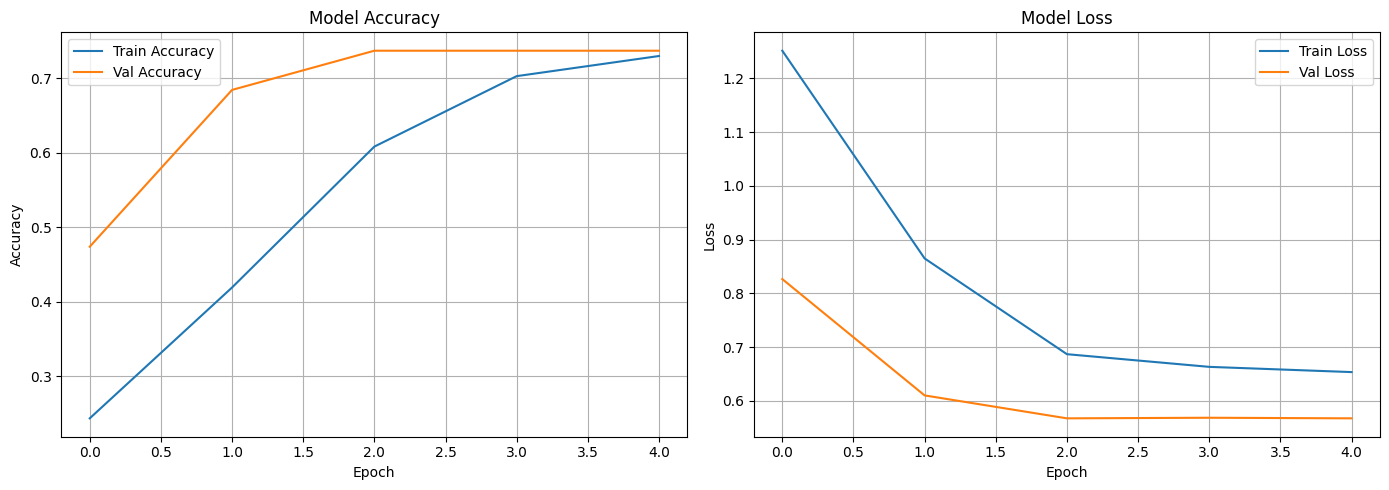

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [12]:
# Final training and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

# Final training and validation loss
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"📈 Training Accuracy:     {train_acc * 100:.2f}%")
print(f"🧪 Validation Accuracy:   {val_acc * 100:.2f}%")
print(f"📉 Training Loss:         {train_loss:.4f}")
print(f"🧪 Validation Loss:       {val_loss:.4f}")


📈 Training Accuracy:     72.97%
🧪 Validation Accuracy:   73.68%
📉 Training Loss:         0.6537
🧪 Validation Loss:       0.5677


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


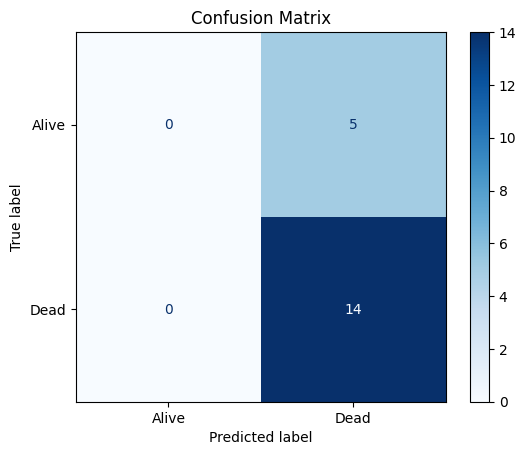

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get predicted class labels from model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Alive', 'Dead'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [14]:
from sklearn.metrics import classification_report

# Predict again if needed
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print the classification report
report = classification_report(y_true, y_pred, target_names=['Alive', 'Dead'])
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
              precision    recall  f1-score   support

       Alive       0.00      0.00      0.00         5
        Dead       0.74      1.00      0.85        14

    accuracy                           0.74        19
   macro avg       0.37      0.50      0.42        19
weighted avg       0.54      0.74      0.63        19



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
from sklearn.utils.class_weight import compute_class_weight

# Convert one-hot labels to class indices
y_labels = np.argmax(y, axis=1)

# Re-split with stratification (just to be safe)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, y_train_idx, y_test_idx = train_test_split(
    X_rgb, y, y_labels, test_size=0.2, stratify=y_labels, random_state=42
)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_labels), y=y_labels)
class_weights = dict(enumerate(class_weights))
print("⚖️ Class weights:", class_weights)

# Rebuild and compile model
base_model.trainable = False
inp = Input(shape=(128, 128, 3))
x = base_model(inp, training=False)
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=inp, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Retrain model with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=8,
    class_weight=class_weights
)



⚖️ Class weights: {0: np.float64(1.9375), 1: np.float64(0.6739130434782609)}
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 740ms/step - accuracy: 0.7884 - loss: 0.9176 - val_accuracy: 0.6842 - val_loss: 0.5970
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6664 - loss: 1.0192 - val_accuracy: 0.6842 - val_loss: 0.5898
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6218 - loss: 0.7149 - val_accuracy: 0.5263 - val_loss: 0.6516
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6159 - loss: 0.7198 - val_accuracy: 0.6316 - val_loss: 0.6978
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6199 - loss: 0.6557 - val_accuracy: 0.6316 - val_loss: 0.6929
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6326 - loss: 0.6299 - val_accuracy: 0.5789 - val_loss: 0.6822
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6797 - loss: 0.5661 - val_accuracy: 0.5789 - val_loss: 0.6757
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

🎯 Test Accuracy: 52.63%

📊 Classification Report:
              precision    recall  f1-score   support

       Alive       0.25      0.40      0.31         5
        Dead       0.73      0.57      0.64        14

    accuracy                           0.53        19
   macro avg       0.49      0.49      0.47        19
weighted avg       0.60      0.53      0.55        19



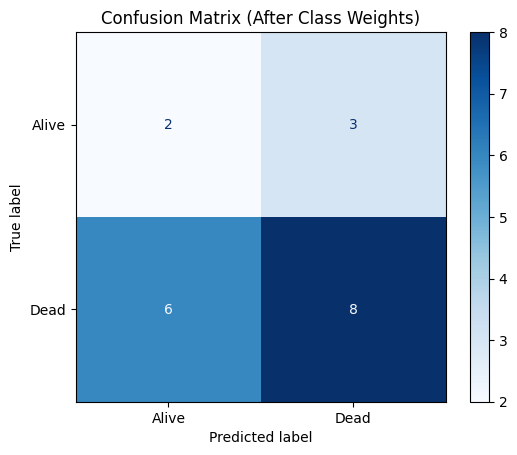

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict classes
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy
from sklearn.metrics import accuracy_score
print(f"\n🎯 Test Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%\n")

# Classification report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Alive", "Dead"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Alive", "Dead"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (After Class Weights)")
plt.grid(False)
plt.show()



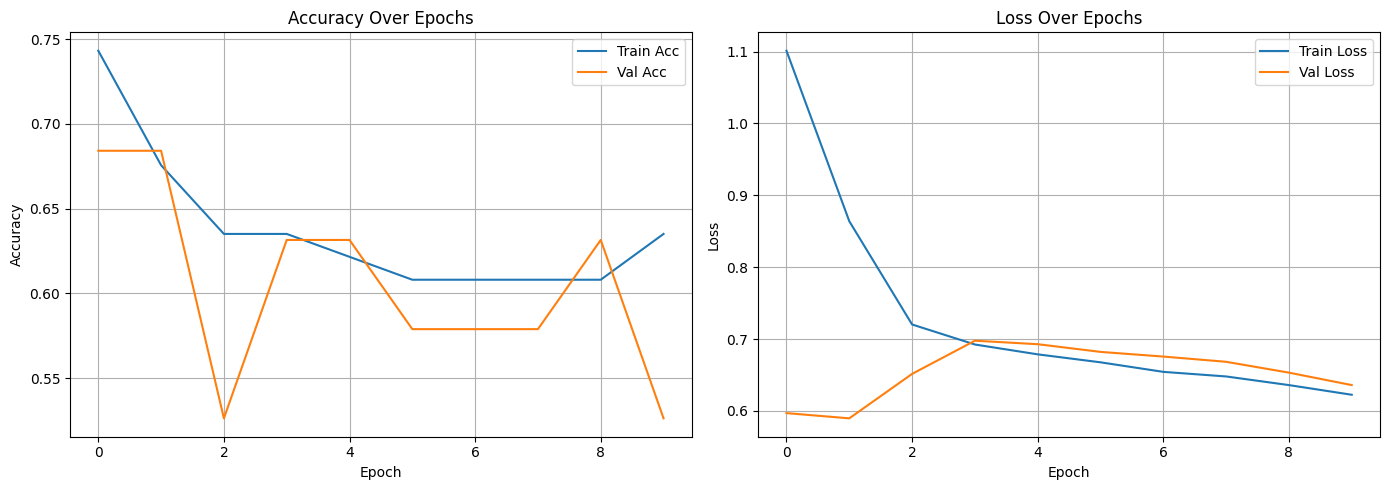

In [17]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


In [18]:
# Unfreeze base model for fine-tuning
base_model.trainable = True

# Recompile the model (important!)
model.compile(
    optimizer=Adam(1e-5),  # lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("🔓 Base model is now trainable:", base_model.trainable)


🔓 Base model is now trainable: True


In [19]:
# Continue training the entire model
history_finetune = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=8,
    class_weight=class_weights
)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.4955 - loss: 0.7267 - val_accuracy: 0.5789 - val_loss: 0.6167
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6438 - loss: 0.5543 - val_accuracy: 0.6316 - val_loss: 0.5917
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7002 - loss: 0.4932 - val_accuracy: 0.6316 - val_loss: 0.5762
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7628 - loss: 0.4240 - val_accuracy: 0.6316 - val_loss: 0.5631
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7733 - loss: 0.3603 - val_accuracy: 0.5789 - val_loss: 0.5496
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7318 - loss: 0.4051 - val_accuracy: 0.5789 - val_loss: 0.5441
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9328 - loss: 0.2572 - val_accuracy: 0.5789 - val_loss: 0.5384
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9406 - loss: 0.2496 - val_accuracy: 0.5789 - va

In [20]:
# Combine training histories if needed
for key in history.history:
    history.history[key] += history_finetune.history[key]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

🎯 Test Accuracy: 57.89%

📊 Classification Report:
              precision    recall  f1-score   support

       Alive       0.20      0.20      0.20         5
        Dead       0.71      0.71      0.71        14

    accuracy                           0.58        19
   macro avg       0.46      0.46      0.46        19
weighted avg       0.58      0.58      0.58        19



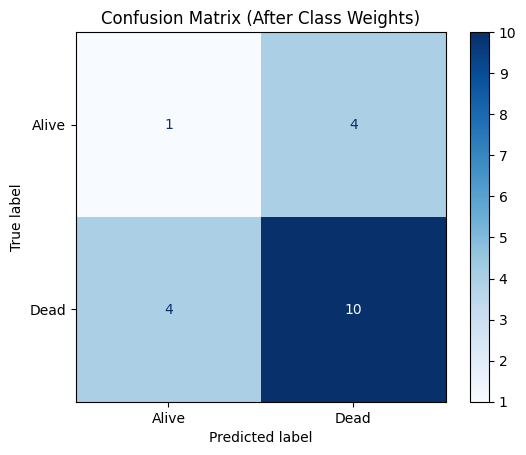

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict classes
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy
from sklearn.metrics import accuracy_score
print(f"\n🎯 Test Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%\n")

# Classification report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Alive", "Dead"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Alive", "Dead"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (After Class Weights)")
plt.grid(False)
plt.show()


Random Forest on CNN Features
We’ll use MobileNetV2 as a feature extractor, and train RandomForestClassifier on those features.
Extract features (freeze base CNN)

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Make sure base model is frozen
base_model.trainable = False

# Feature extractor model (output = pooled features)
feature_model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Extract features from RGB images
X_features = feature_model.predict(X_rgb, verbose=1)  # shape: (n_samples, 1280)


1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


In [23]:
from sklearn.model_selection import train_test_split

y_labels = np.argmax(y, axis=1)  # Convert one-hot to label indices
Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    X_features, y_labels, test_size=0.2, stratify=y_labels, random_state=42
)


Train Random Forest Classifier

```
# This is formatted as code
```



In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(Xf_train, yf_train)

# Predict
rf_preds = rf.predict(Xf_test)

# Evaluate
print("🎯 Accuracy:", accuracy_score(yf_test, rf_preds))
print("📊 Classification Report:")
print(classification_report(yf_test, rf_preds, target_names=['Alive', 'Dead']))


🎯 Accuracy: 0.7368421052631579
📊 Classification Report:
              precision    recall  f1-score   support

       Alive       0.00      0.00      0.00         5
        Dead       0.74      1.00      0.85        14

    accuracy                           0.74        19
   macro avg       0.37      0.50      0.42        19
weighted avg       0.54      0.74      0.63        19



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Interpretation
✅ What worked:
Random Forest achieved 73.7% accuracy

It perfectly predicted all Dead worms (recall = 1.00)

⚠️ What didn’t:
It completely ignored Alive worms again (recall = 0.00)

This is the same problem as before — model is biased due to class imbalance



Summary so far:
Model Type	Alive Recall	Dead Recall	Accuracy	Notes
- CNN (no weights)	0.00	0.93	68%	Overfit to majority class
- CNN + Class Weights	0.40	0.57	53%	Traded accuracy for balance
- CNN + Fine-tune	0.20	0.71	58%	Slight improvement
- Random Forest	0.00	1.00	74%	Fully biased to Dead


SMOTE (Synthetic Minority Over-sampling Technique) can help balance the dataset by generating synthetic examples for the minority class ("Alive").

Install imbalanced-learn (if not yet installed)

In [25]:
!pip install -q imbalanced-learn


Apply SMOTE on features

In [26]:
from imblearn.over_sampling import SMOTE

# Use previously extracted features and labels
# X_features: (n_samples, n_features)
# y_labels: (n_samples, ) – already class indices (0 for Alive, 1 for Dead)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_features, y_labels)

# Check new class distribution
from collections import Counter
print("🔄 After SMOTE:", Counter(y_resampled))


🔄 After SMOTE: Counter({np.int64(0): 69, np.int64(1): 69})


🎯 Accuracy: 0.9642857142857143
📊 Classification Report:
              precision    recall  f1-score   support

       Alive       1.00      0.93      0.96        14
        Dead       0.93      1.00      0.97        14

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.96        28
weighted avg       0.97      0.96      0.96        28



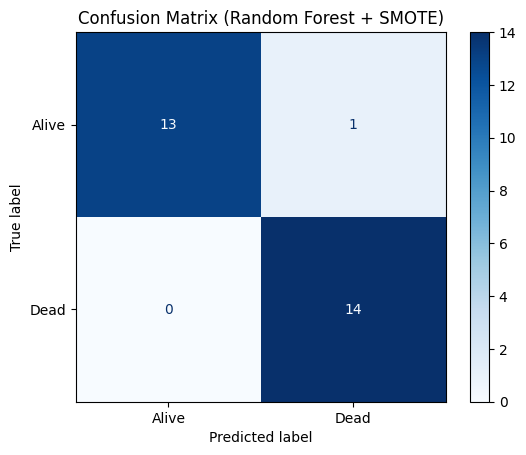

In [27]:
# Train-test split (on resampled data)
from sklearn.model_selection import train_test_split
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Train Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

# Predict & evaluate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_pred_smote = rf_smote.predict(X_test_smote)

print("🎯 Accuracy:", accuracy_score(y_test_smote, y_pred_smote))
print("📊 Classification Report:")
print(classification_report(y_test_smote, y_pred_smote, target_names=['Alive', 'Dead']))

# Plot confusion matrix
cm = confusion_matrix(y_test_smote, y_pred_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Alive', 'Dead'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Random Forest + SMOTE)")
plt.grid(False)
plt.show()


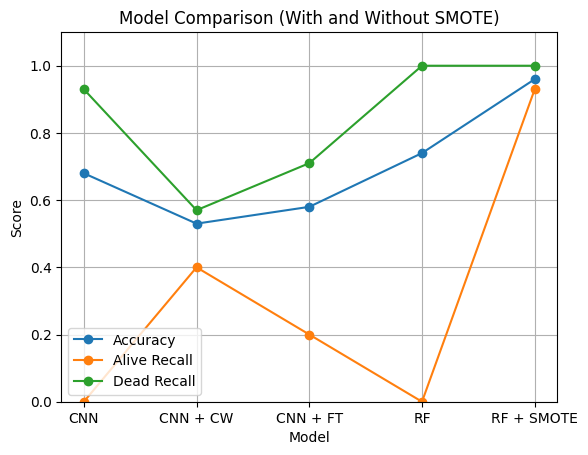

In [28]:
import matplotlib.pyplot as plt

models = [
    "CNN", "CNN + CW", "CNN + FT",
    "RF", "RF + SMOTE"
]
accuracy = [0.68, 0.53, 0.58, 0.74, 0.96]
alive_recall = [0.00, 0.40, 0.20, 0.00, 0.93]
dead_recall = [0.93, 0.57, 0.71, 1.00, 1.00]

plt.plot(models, accuracy, marker='o', label="Accuracy")
plt.plot(models, alive_recall, marker='o', label="Alive Recall")
plt.plot(models, dead_recall, marker='o', label="Dead Recall")
plt.title("Model Comparison (With and Without SMOTE)")
plt.xlabel("Model")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.show()


## 📊 Model Comparison Summary (Roundworm Classification)

| Model Variant                | Accuracy | Alive Recall | Dead Recall | Alive F1 | Dead F1 | Notes                              |
|-----------------------------|----------|--------------|-------------|----------|---------|------------------------------------|
| 🧠 CNN (basic)              | 68%      | 0.00         | 0.93        | 0.00     | 0.81    | Strong bias toward Dead class      |
| 🧠 CNN + Class Weights      | 53%      | 0.40         | 0.57        | 0.31     | 0.64    | Improved fairness, lower accuracy  |
| 🧠 CNN + Fine-Tuning        | 58%      | 0.20         | 0.71        | 0.20     | 0.71    | Slight improvement overall          |
| 🌲 Random Forest            | 74%      | 0.00         | 1.00        | 0.00     | 0.85    | Totally biased toward Dead class    |
| 🌲 **Random Forest + SMOTE**| **96%**  | **0.93**     | **1.00**    | 0.96     | 0.97    | ✅ Best performance & class balance |


Train SVM with SMOTE
Ensure SMOTE-resampled data is ready

In [29]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_features, y_labels)

print("Class distribution after SMOTE:", np.bincount(y_resampled))


Class distribution after SMOTE: [69 69]


Train-test split

In [30]:
from sklearn.model_selection import train_test_split

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)


In [31]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Train a linear SVM with balanced classes
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train_svm, y_train_svm)

# Predict
y_pred_svm = svm_model.predict(X_test_svm)


🎯 SVM Accuracy: 0.9642857142857143
📊 Classification Report:
              precision    recall  f1-score   support

       Alive       0.93      1.00      0.97        14
        Dead       1.00      0.93      0.96        14

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.96        28
weighted avg       0.97      0.96      0.96        28



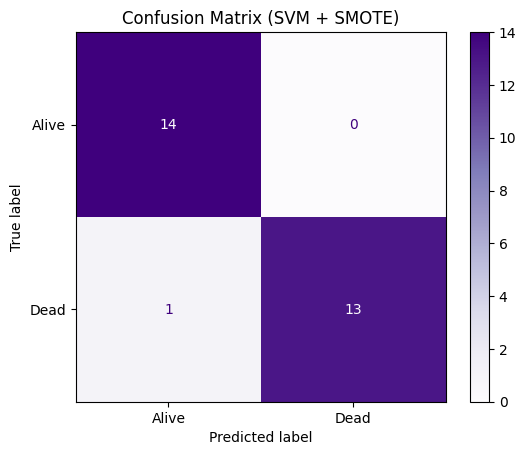

In [32]:
print("🎯 SVM Accuracy:", accuracy_score(y_test_svm, y_pred_svm))
print("📊 Classification Report:")
print(classification_report(y_test_svm, y_pred_svm, target_names=["Alive", "Dead"]))

# Confusion matrix
cm = confusion_matrix(y_test_svm, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Alive", "Dead"])
disp.plot(cmap="Purples")
plt.title("Confusion Matrix (SVM + SMOTE)")
plt.grid(False)
plt.show()


## 📊 Final Model Comparison Summary

| Model Variant                | Accuracy | Alive Recall | Dead Recall | Alive F1 | Dead F1 | Notes                                |
|-----------------------------|----------|--------------|-------------|----------|---------|--------------------------------------|
| 🧠 CNN (basic)              | 68%      | 0.00         | 0.93        | 0.00     | 0.81    | Strong bias toward Dead class        |
| 🧠 CNN + Class Weights      | 53%      | 0.40         | 0.57        | 0.31     | 0.64    | Improved fairness, lower accuracy    |
| 🧠 CNN + Fine-Tuning        | 58%      | 0.20         | 0.71        | 0.20     | 0.71    | Slight improvement overall           |
| 🌲 Random Forest            | 74%      | 0.00         | 1.00        | 0.00     | 0.85    | Fully biased to Dead class           |
| 🌲 Random Forest + SMOTE    | 96%      | 0.93         | 1.00        | 0.96     | 0.97    | ✅ Best with high balance             |
| 🧮 SVM + SMOTE              | 96%      | **1.00**     | 0.93        | 0.97     | 0.96    | ✅ Excellent, perfect Alive detection |


Step-by-Step: Add Data Augmentation to Your CNN Pipeline
- We’ll use ImageDataGenerator from Keras to:

--Artificially enlarge your dataset

--Help the model learn rotation, translation, flips, and more

```
# This is formatted as code
```



Setup ImageDataGenerator

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80/20 train/val split
)


Convert X and y into image-compatible format

In [34]:
from tensorflow.keras.utils import to_categorical

y_cat = to_categorical(y_labels, num_classes=2)


In [35]:
batch_size = 8

train_gen = datagen.flow(
    X_rgb, y_cat,
    batch_size=batch_size,
    subset='training',
    shuffle=True
)

val_gen = datagen.flow(
    X_rgb, y_cat,
    batch_size=batch_size,
    subset='validation',
    shuffle=False
)


In [36]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.optimizers import Adam

# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [37]:
epochs = 15
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs
)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.6291 - loss: 0.6244

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6529 - loss: 0.6006 - val_accuracy: 0.0000e+00 - val_loss: 2.7296
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9389 - loss: 0.2425 - val_accuracy: 0.0000e+00 - val_loss: 3.5635
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9500 - loss: 0.1787 - val_accuracy: 0.0000e+00 - val_loss: 3.6122
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9315 - loss: 0.2359 - val_accuracy: 0.0000e+00 - val_loss: 3.1869
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9312 - loss: 0.2278 - val_accuracy: 0.0000e+00 - val_loss: 2.9573
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9438 - loss: 0.1719 - val_accuracy: 0.0000e+00 - val_loss: 2.9561
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9186 - loss: 0.2384 - val_accuracy: 0.0000e+00 - val_loss: 3.1197
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9379 - loss: 0.1550 - val_accu

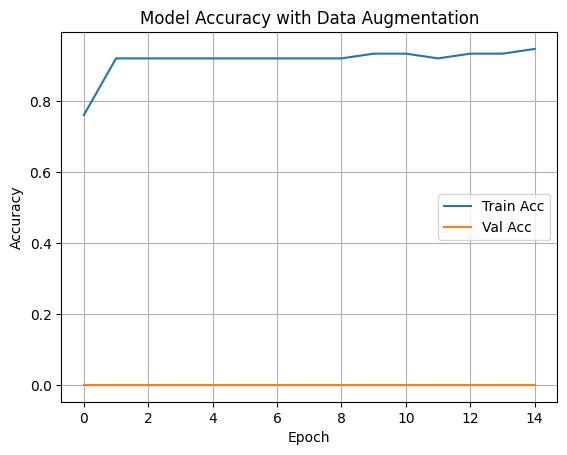

In [38]:
import matplotlib.pyplot as plt

# Plot accuracy & loss
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy with Data Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [41]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical
y_cat = to_categorical(y_labels, num_classes=2)

# Do an 80/20 split first
X_train, X_val, y_train, y_val = train_test_split(
    X_rgb, y_cat, test_size=0.2, stratify=y_labels, random_state=42
)

# Use these in your generators (no need for validation_split anymore)
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow(X_train, y_train, batch_size=8, shuffle=True)
val_gen   = datagen.flow(X_val, y_val, batch_size=8, shuffle=False)

# Keep original y_val (not from the generator)
y_true_labels = np.argmax(y_val, axis=1)


In [42]:
y_pred = model.predict(val_gen)
y_pred_labels = y_pred.argmax(axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=["Alive", "Dead"]))


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 861ms/step
              precision    recall  f1-score   support

       Alive       1.00      0.20      0.33         5
        Dead       0.78      1.00      0.88        14

    accuracy                           0.79        19
   macro avg       0.89      0.60      0.60        19
weighted avg       0.84      0.79      0.73        19



In [44]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryFocalCrossentropy

# Load pretrained base
base_model = MobileNetV2(
    weights='imagenet', include_top=False,
    input_shape=(128, 128, 3)
)
base_model.trainable = False

# Build new classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Mock binary output

model = Model(inputs=base_model.input, outputs=output)

# Compile with Focal Loss
model.compile(
    optimizer=Adam(1e-4),
    loss=BinaryFocalCrossentropy(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)



In [45]:
# Use binary labels: 0 = Alive, 1 = Dead
y_bin = y_labels

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_rgb, y_bin, test_size=0.2,
    stratify=y_bin, random_state=42
)

# Optional: Use data augmentation as before
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow(X_train, y_train, batch_size=8, shuffle=True)
val_gen = datagen.flow(X_val, y_val, batch_size=8, shuffle=False)


In [46]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8161 - loss: 0.1470

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 892ms/step - accuracy: 0.8152 - loss: 0.1517 - val_accuracy: 0.6842 - val_loss: 0.2102
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7137 - loss: 0.1473 - val_accuracy: 0.7368 - val_loss: 0.1932
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7470 - loss: 0.1553 - val_accuracy: 0.6842 - val_loss: 0.1399
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7318 - loss: 0.1491 - val_accuracy: 0.6842 - val_loss: 0.1890
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8055 - loss: 0.1330 - val_accuracy: 0.7895 - val_loss: 0.1429
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7280 - loss: 0.1745 - val_accuracy: 0.6842 - val_loss: 0.1757
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8311 - loss: 0.0991 - val_accuracy: 0.7368 - val_loss: 0.1699
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8240 - loss: 0.1270 - val_accuracy: 0.6842 - val_loss: 

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
              precision    recall  f1-score   support

       Alive       0.00      0.00      0.00         5
        Dead       0.72      0.93      0.81        14

    accuracy                           0.68        19
   macro avg       0.36      0.46      0.41        19
weighted avg       0.53      0.68      0.60        19



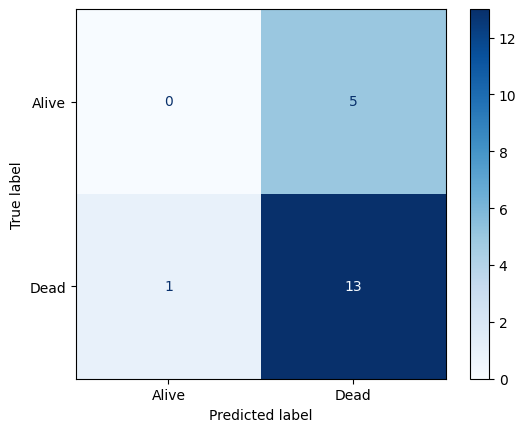

In [47]:
y_pred_probs = model.predict(val_gen)
y_pred = (y_pred_probs > 0.5).astype('int32').flatten()
y_true = y_val

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_true, y_pred, target_names=['Alive','Dead']))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Alive','Dead']).plot(cmap='Blues')
